# Interpolate 5D beam density

$x_3$ = x position at VS34 \
$y_3$ = y position at VS34 \
$x_2$ = position of VT06 slit \
$y_1$ = position of HZ04 slit \
$x_1$ = position of VT04 slit

$$
\begin{aligned}
x &= x_1 \\
y &= y_1 \\
x' &= \frac{x_2 - 0.35 x_1}{s_2 - s_1} \\
y' &= \frac{y_3 - y_1}{s_3 - s_1} \\
w  &= f(x_3, x_2, x_1) \\ 
\end{aligned}
$$

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Load 5D array 

In [3]:
folder = '.'
filenames = os.listdir(folder)
for filename in filenames:
    if filename.startswith('rawgrid'):
        print(filename)
    if filename.startswith('slit_coordinates'):
        print(filename)

slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy
rawgrid_shape.txt
rawgrid_220429190854-scan-xxpy-image-ypdE.mmp


In [4]:
filename = 'rawgrid_220429190854-scan-xxpy-image-ypdE.mmp'
coordfilename = 'slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy'

In [5]:
shape = tuple(np.loadtxt(join(folder, 'rawgrid_shape.txt')).astype(int))
print(shape)

(33, 33, 33, 147, 194)


In [6]:
file = open(join(folder, 'im_dtype.txt'), 'r')
dtype = file.readline()
file.close()
print(dtype)

float64


In [7]:
a5d = np.memmap(join(folder, filename), shape=shape, dtype=dtype, mode='r')
print(np.info(a5d))

class:  memmap
shape:  (33, 33, 33, 147, 194)
strides:  (248448816, 7528752, 228144, 1552, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f0217ae1000
byteorder:  little
byteswap:  False
type: float64
None


Flip the y3 axis (the image comes in upside-down). The x3 axis is also flipped relative to the beam frame. Finall, the y1 slit coordinates are flipped relative to the beam frame. **(What about the x and x' slits?)**

In [8]:
a5d = a5d[:, :, ::-1, ::-1, ::-1]

## Load slit coordinates

In [9]:
coords_3d = np.load(coordfilename)  # [X1, X2, Y1]
coords_3d.shape

(3, 33, 33, 33)

In [10]:
dims = ["x1", "x2", "y1", "y3", "x3"]
dim_to_int = {dim: i for i, dim in enumerate(dims)}

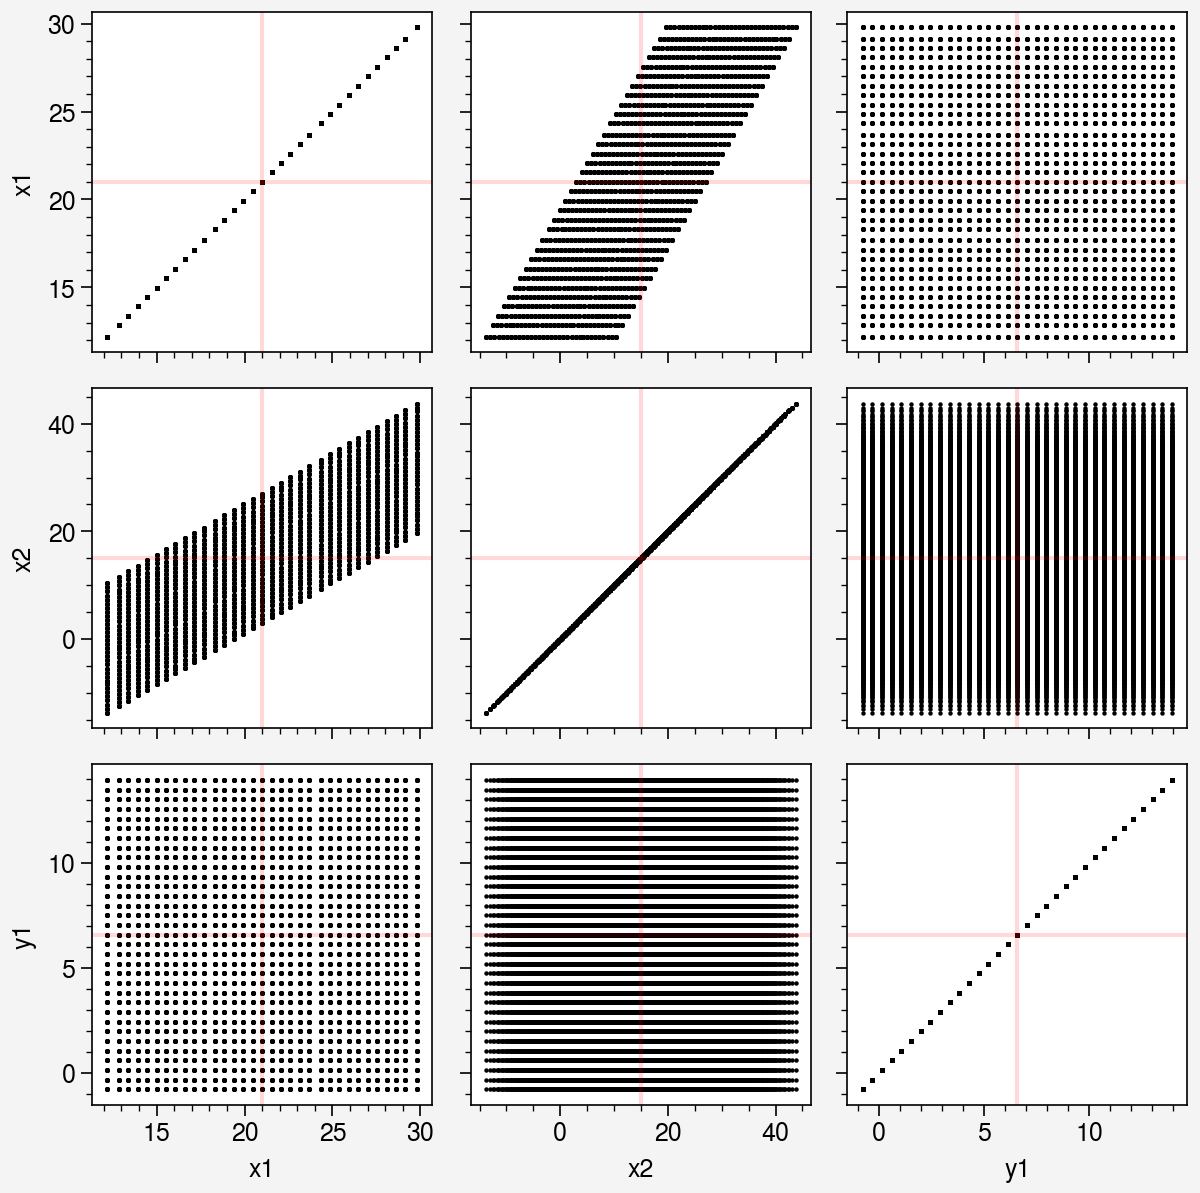

In [12]:
fig, axes = pplt.subplots(nrows=3, ncols=3, figwidth=6, spanx=False, spany=False)
for i in range(3):
    for j in range(3):
        U = coords_3d[j]
        V = coords_3d[i]
        ax = axes[i, j]
        ax.scatter(U.ravel(), V.ravel(), s=1, color='black')
        ax.axvline(np.mean(U), color='red', alpha=0.15)
        ax.axhline(np.mean(V), color='red', alpha=0.15)
    axes[i, 0].format(ylabel=dims[i])
    axes[-1, i].format(xlabel=dims[i])
plt.show()

In [13]:
# y1_gv = coords_3d[2, 0, 0, :]
# y3_gv = np.arange(shape[3])
# x3_gv = np.arange(shape[4])
# gvs = [None, None, y1_gv, y3_gv, x3_gv]

Copy the grids to cover five dimensions.

In [14]:
X1, X2, Y1 = coords_3d
X1 = utils.copy_into_new_dim(X1, shape[3:], axis=-1)
X2 = utils.copy_into_new_dim(X2, shape[3:], axis=-1)
Y1 = utils.copy_into_new_dim(Y1, shape[3:], axis=-1)

In [15]:
print('X1.shape =', X1.shape)
print('X2.shape =', X2.shape)
print('Y1.shape =', Y1.shape)

X1.shape = (33, 33, 33, 147, 194)
X2.shape = (33, 33, 33, 147, 194)
Y1.shape = (33, 33, 33, 147, 194)


In [19]:
Y3, X3 = np.meshgrid(np.arange(shape[3]), np.arange(shape[4]), indexing='ij')
Y3 = utils.copy_into_new_dim(Y3, shape[:3], axis=0)
X3 = utils.copy_into_new_dim(X3, shape[:3], axis=0)

In [20]:
print('Y3.shape =', Y3.shape)
print('X3.shape =', X3.shape)

Y3.shape = (33, 33, 33, 147, 194)
X3.shape = (33, 33, 33, 147, 194)


Make list of center coordinates. `coords_` has coordinates in raw slit values.

In [21]:
X1 = X1 - np.mean(X1)
X2 = X2 - np.mean(X2)
Y1 = Y1 - np.mean(Y1)
Y3 = Y3 - np.mean(Y3)
X3 = X3 - np.mean(X3)
coords_ = [X1, X2, Y1, Y3, X3]

In [22]:
for i, dim in enumerate(dims):
    print('dim =', dim)
    U = coords_[i]
    axes = [k for k in range(U.ndim) if k != i]
    idx = utils.make_slice(U.ndim, axes, ind=[0, 0, 0, 0])
    print(U[idx])
    print()

dim = x1
[-8.79636364e+00 -8.15272727e+00 -7.61636364e+00 -7.08000000e+00
 -6.54363636e+00 -6.00727273e+00 -5.47090909e+00 -4.93454545e+00
 -4.39818182e+00 -3.86181818e+00 -3.32545455e+00 -2.68181818e+00
 -2.14545455e+00 -1.60909091e+00 -1.07272727e+00 -5.36363636e-01
 -4.61497507e-12  5.36363636e-01  1.07272727e+00  1.60909091e+00
  2.14545455e+00  2.68181818e+00  3.32545455e+00  3.86181818e+00
  4.39818182e+00  4.93454545e+00  5.47090909e+00  6.00727273e+00
  6.54363636e+00  7.08000000e+00  7.61636364e+00  8.15272727e+00
  8.79636364e+00]

dim = x2
[-28.7409503  -28.00754424 -27.27413818 -26.39405091 -25.66064485
 -24.92723879 -24.19383273 -23.46042667 -22.72702061 -21.99361455
 -21.26020848 -20.52680242 -19.64671515 -18.91330909 -18.17990303
 -17.44649697 -16.71309091 -15.97968485 -15.24627879 -14.51287273
 -13.77946667 -12.89937939 -12.16597333 -11.43256727 -10.69916121
  -9.96575515  -9.23234909  -8.49894303  -7.76553697  -7.03213091
  -6.15204364  -5.41863758  -4.68523152]

dim =

## View 5D array in slit-screen coordinates

### Projections 

In [23]:
frac_thresh = 1e-5
# frac_thresh = None

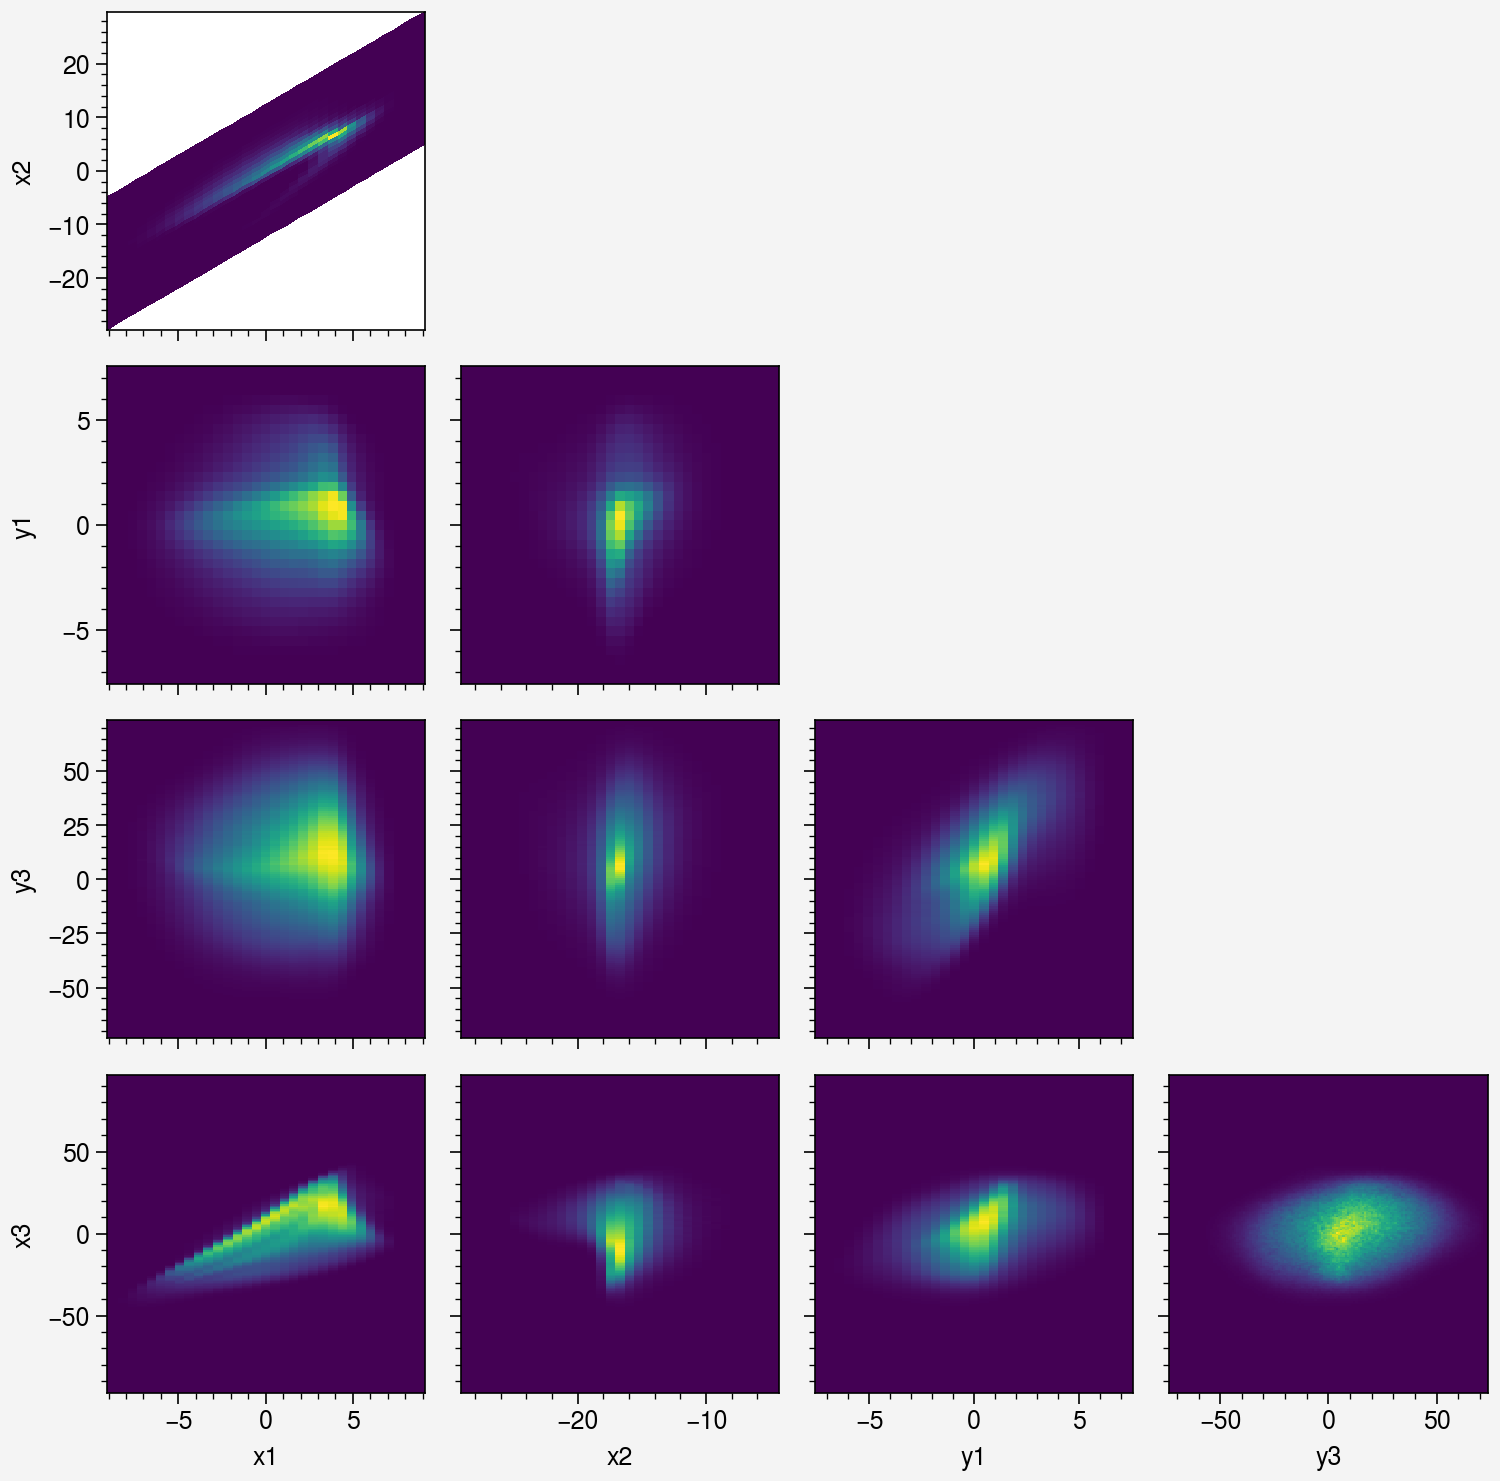

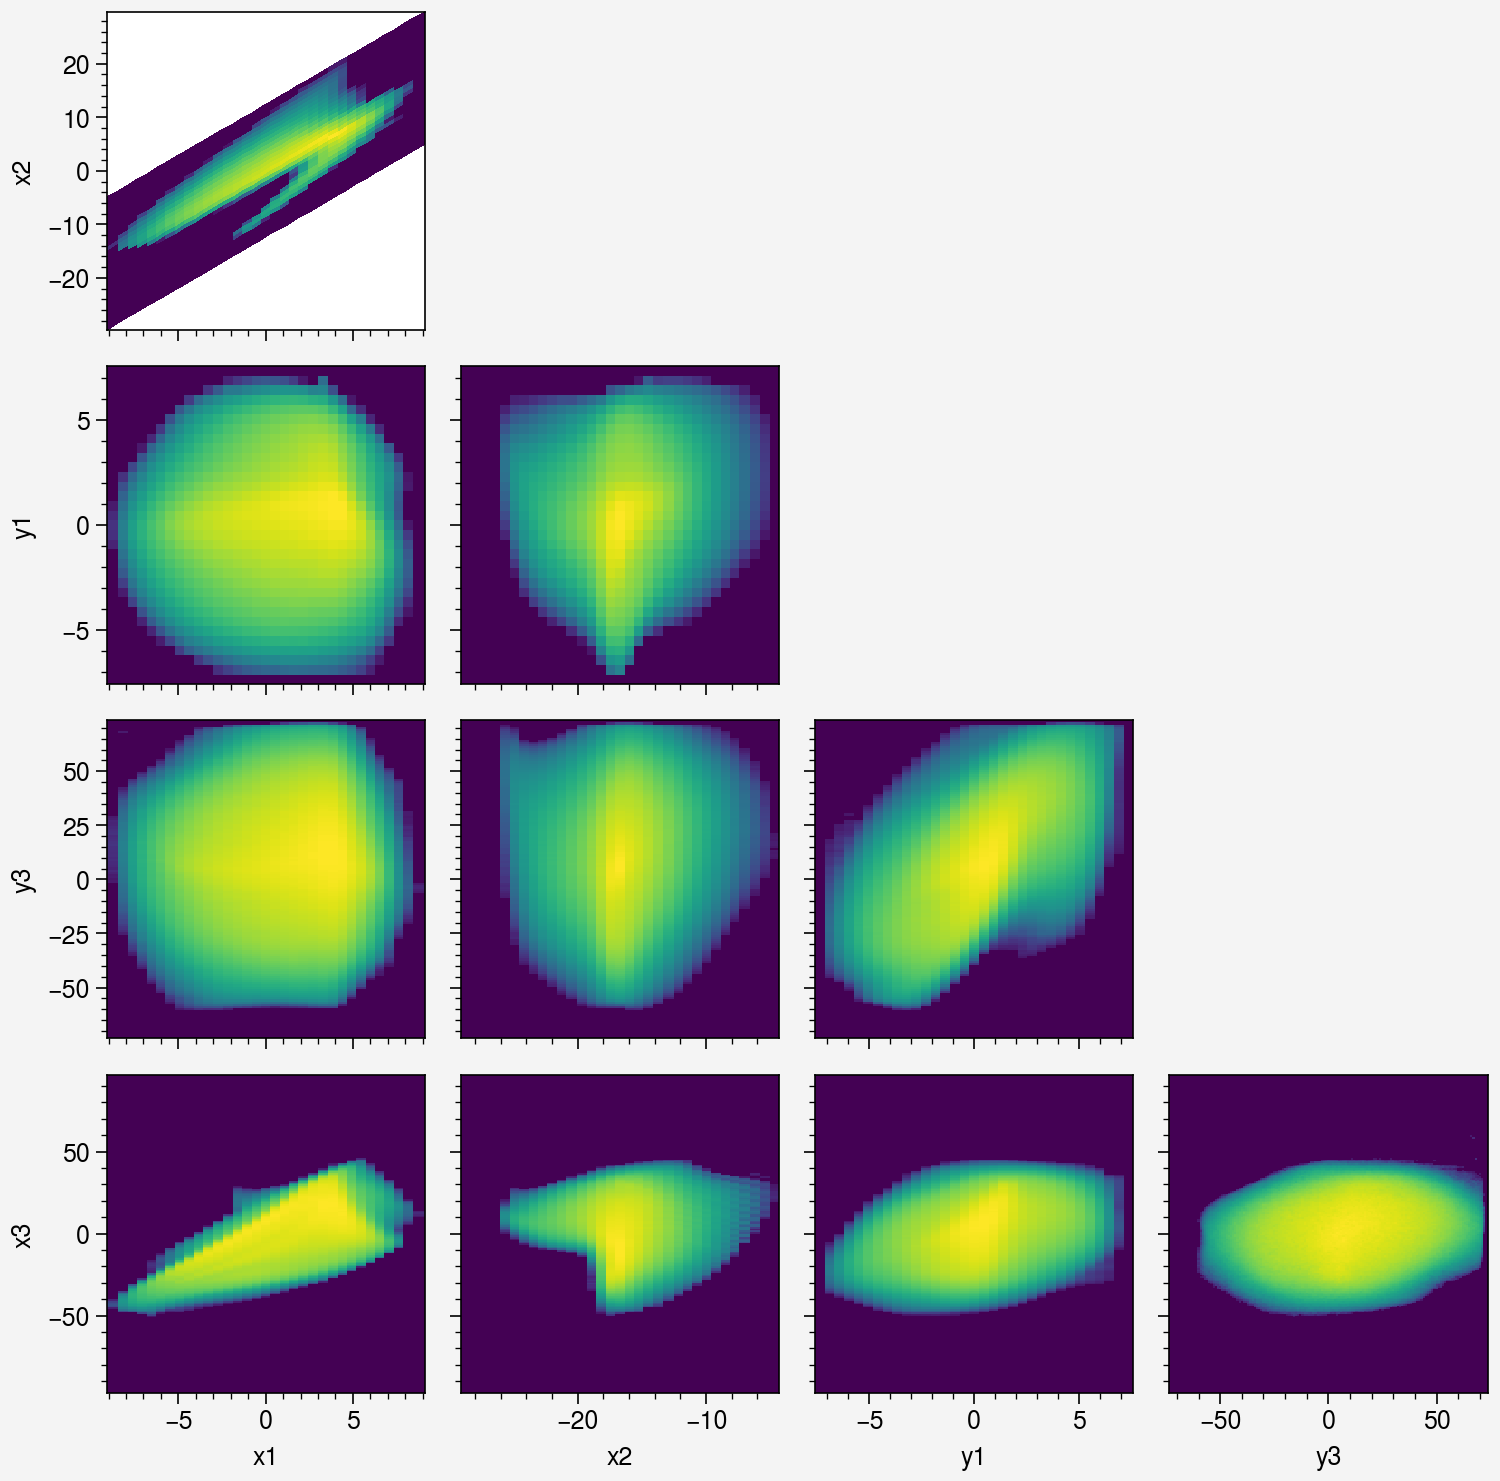

In [42]:
for norm in [None, 'log']:
    axes = mplt.corner(
        a5d,
        coords=coords_,
        labels=dims,
        norm=norm,
        diag_kind='None',
        # prof='edges',
        prof_kws=dict(lw=1.0),
        fig_kws=dict(),
        frac_thresh=frac_thresh,
    )
    plt.savefig(f"_output/corner_log{norm == 'log'}.png")
    plt.show()

### Slices

In [43]:
ind = np.unravel_index(np.argmax(a5d), a5d.shape)
ind = tuple([i for i in ind])
print(ind)

(22, 17, 19, 88, 125)


In [65]:
axes_slice = [(k, j, i) for i in range(a5d.ndim) for j in range(i) for k in range(j)]
axes_view = [[i for i in range(a5d.ndim) if i not in axis]
                  for axis in axes_slice]
for axis, axis_view in zip(axes_slice, axes_view):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    a5d_slice = a5d[idx]
    a5d_slice = a5d_slice / np.max(a5d_slice)

    axes_not_slice = [i for i in range(5) if i not in axes_slice]
    x, y = [coords_[i][idx] for i in axes_not_slice]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(a5d_slice, x=x, y=y, ax=ax, frac_thresh=frac_thresh, norm=norm, colorbar=True)
    dim1, dim2 = [dims[i] for i in axes_not_slice]
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    # Save the figure.
    string = '_output/slice_'
    for i in axes:
        string += f'_{dims[i]}-{ind[i]}'
    plt.savefig(string + '.png')
    plt.show()

[(0, 1, 2),
 (0, 1, 3),
 (0, 2, 3),
 (1, 2, 3),
 (0, 1, 4),
 (0, 2, 4),
 (1, 2, 4),
 (0, 3, 4),
 (1, 3, 4),
 (2, 3, 4)]

## Interactive 

In [ ]:
cmaps = ['viridis', 'dusk_r', 'mono_r', 'grays', 'plasma', 'blues_r', 'rocket', 'mako', 'stellar_r',]

In [ ]:
def update_projection(a5d, dim1='y3', dim2='x3', cfix=False, log=False, reverse=False, **plot_kws):
    if dim1 == dim2:
        raise ValueError('dim1 == dim2')
    dims = [dim1, dim2]
    norm = 'log' if log else None
    plot_kws['cmap'] = pplt.Colormap(plot_kws.pop('cmap'), reverse=reverse)
    image = project(a5d, axis=[dim_to_int[dim] for dim in dims])
    image = image / image.max()
    fig, ax = pplt.subplots()
    mplt.plot_image(image, ax=ax, profx=True, profy=True, prof_kws=dict(scale=0.15), 
                    colorbar=True, norm=norm, **plot_kws)
    ax.format(xlabel=dim1, ylabel=dim2)
    plt.show()

In [ ]:
fig = go.FigureWidget()
heatmap = fig.add_heatmap()

@interact(dim1=dims, dim2=dims, cmap=cmaps, reverse=False, log=False, discrete=False)
def update(dim1='y3', dim2='x3', cmap='viridis', reverse=False, log=False, discrete=False):
    with fig.batch_update():
        heatmap.data = update_projection(
            a5d, dim1=dim1, dim2=dim2, log=log, discrete=discrete,
            cmap=cmap, frac_thresh=frac_thresh, reverse=reverse,
        )

## Coordinate transform

Convert x3 and y3 from pixels to mm.

In [ ]:
mm_per_pixel = 0.0659  # 1X zoom
mm_per_pixel *= 2.0  # 0.5X zoom
mm_per_pixel *= 2.0  # downscale by factor of 2.0

X3 = X3 * mm_per_pixel
Y3 = Y3 * mm_per_pixel

Build the transfer matrices between slits and the screen.

In [ ]:
a2mm = 1.009  # assume same as first dipole
rho = 0.3556
GL05 = 0.0
GL06 = 0.0
l1 = 0.0
l2 = 0.0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for first/last dipole-screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance

ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=a2mm*1e3)
Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

Compute x', y', and energy w.

In [ ]:
Y = Y1.copy()
YP = ecalc.calculate_yp(Y.ravel() * 1e-3, Y3.ravel() * 1e-3, Mscreen)
YP = YP.reshape(shape)

X = X1.copy()
XP = ecalc.calculate_xp(X.ravel() * 1e-3, X2.ravel() * 1e-3, Mslit)
XP = XP.reshape(shape)

W = ecalc.calculate_dE_screen(X3.ravel() * 1e-3, 0.0, X.ravel() * 1e-3, XP.ravel(), Mscreen)
W = W.reshape(shape)

# Convert from m-rad to mm-mrad
YP *= 1e3
XP *= 1e3
W *= 1e3

In [ ]:
X = X.copy()
Y = Y.copy()
XP = XP.copy()
YP = YP.copy()
W = W.copy()
del(X1, X2, Y1, X3, Y3)

Make list of centered phase space coordinate grids.

In [ ]:
coords = [X, XP, Y, YP, W]
for coord in tqdm(coords):
    coord = coord - np.mean(coord)

In [ ]:
pdims = ["x [mm]", "x' [mrad]", "y [mm]", "y' [mrad]", "w [keV?]"]

In [ ]:
# fig, axes = pplt.subplots(nrows=5, ncols=5, figwidth=10.0, spanx=False, spany=False)
# for i in range(5):
#     for j in range(5):
#         U = coords_[j]
#         V = coords_[i]
#         axis_view = (i, j)
#         axis_slice = [k for k in range(5) if k not in axis_view]
#         idx = utils.make_slice(5, axis_slice, ind=(0, 0, 0))
#         ax = axes[i, j]
#         ax.scatter(U[idx].ravel(), V[idx].ravel(), s=1, color='black')
#         ax.axvline(np.mean(U), color='red', alpha=0.15)
#         ax.axhline(np.mean(V), color='red', alpha=0.15)
#     axes[i, 0].format(ylabel=pdims[i])
#     axes[-1, i].format(xlabel=pdims[i])
# plt.show()

In [ ]:
for norm in [None, 'log']:
    axes = mplt.corner(
        a5d,
        coords=coords,
        labels=pdims,
        norm=norm,
        diag_kind='None',
        # prof='edges',
        prof_kws=dict(lw=1.0),
        fig_kws=dict(),
        frac_thresh=frac_thresh,
    )
    # plt.savefig(f"_output/corner_ps_log{norm == 'log'}.png")
    plt.show()

Put energy on evenly-spaced grid.

First test 2D interpolation

In [ ]:
for j in range(5):
    for k in range(j):
        axis_view = (k, j)
        H = utils.project(a5d, axis_view)
        H = H / np.max(H)

        axis_slice = [i for i in range(a5d.ndim) if i not in axis_view]
        idx = utils.make_slice(a5d.ndim, axis_slice, ind=[0, 0, 0])
        U = coords[axis_view[0]][idx]
        V = coords[axis_view[1]][idx]
        u_new = np.linspace(np.min(U), np.max(U), shape[axis_view[0]])
        v_new = np.linspace(np.min(V), np.max(V), shape[axis_view[1]])

        def interp2d(**kws):
            points = (U.ravel(), V.ravel())
            values = H.ravel()  
            U_new, V_new = np.meshgrid(u_new, v_new, indexing='ij')
            new_points = (U_new.ravel(), V_new.ravel())
            H_new = interpolate.griddata(points, values, new_points, fill_value=0.0)
            H_new = H_new.reshape(len(u_new), len(v_new))
            H_new[H_new < 0] = 0
            return H_new

        fig, axes = pplt.subplots(ncols=2, spanx=False)
        pkws = dict(colorbar=True, norm='log', frac_thresh=1e-5)
        mplt.plot_image(H / np.max(H), x=U, y=V, ax=axes[0], **pkws)
        H_new = interp2d()
        mplt.plot_image(H_new / np.max(H_new), x=u_new, y=v_new, ax=axes[1], **pkws)
        axes[1].contour(U.T, V.T, H.T, color='white', lw=1, alpha=0.4, label='original')
        axes.format(
            xlabel=pdims[axis_view[0]],
            ylabel=pdims[axis_view[1]],
            toplabels=['Measured', 'Interpolated']
        )
        plt.show()

Must grid the the x-x'-w distribution for each y-y', and must grid the y-y' distribution for each x-x'-w.

In [ ]:
new_shape = list(shape)
new_shape = tuple(new_shape)
print(new_shape)

In [ ]:
x_gv_new = np.linspace(np.min(X), np.max(X), new_shape[0])
xp_gv_new = np.linspace(np.min(XP), np.max(XP), new_shape[1])
y_gv_new = np.linspace(np.min(Y), np.max(Y), new_shape[2])
yp_gv_new = np.linspace(np.min(YP), np.max(YP), new_shape[3])
w_gv_new = np.linspace(np.min(W), np.max(W), new_shape[4])

In [ ]:
a5d_new = np.zeros(a5d.shape)

## Interpolate w for each x-x' 

In [ ]:
new_points = w_gv_new
for i in trange(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            for l in range(shape[3]):
                points = coords[4][i, j, k, l, :]
                values = a5d[i, j, k, l, :]
                a5d_new[i, j, k, l] = interpolate.griddata(points, values, new_points, fill_value=0.0)

### Interpolate y-y' for each x, x', w

In [ ]:
new_points = tuple([G.ravel() for G in np.meshgrid(y_gv_new, yp_gv_new, indexing='ij')])
points = (
    coords[2][0, 0, :, :, 0].ravel(),
    coords[3][0, 0, :, :, 0].ravel(),
)

In [ ]:
for i in trange(shape[0]):
    for j in trange(shape[1]):
        for m in range(shape[4]):
            values = a5d[i, j, :, :, m].ravel()
            _arr = interpolate.griddata(
                points,
                values,
                new_points,
                fill_value=0.0, 
                method='linear',
            )
            a5d_new[i, j, :, :, m] = _arr.reshape((new_shape[2], new_shape[3]))

### Interpolate x-x' for each y-y'

In [ ]:
new_points = tuple([G.ravel() for G in np.meshgrid(x_gv_new, xp_gv_new, indexing='ij')])
points = (
    coords[0][:, :, 0, 0, :].ravel(),
    coords[1][:, :, 0, 0, :].ravel(),
)

In [ ]:
for k in trange(a5d.shape[2]):
    for l in trange(a5d.shape[3]):   
        values = a5d[:, :, k, l, :].ravel()
        _arr = interpolate.griddata(
            points,
            values,
            new_points,
            fill_value=0.0,
        )
        a5d_new[:, :, k, l, :] = _arr.reshape((new_shape[0], new_shape[1], new_shape[4]))

In [ ]:
for i in range(5):
    for j in range(i):
        fig, axes = pplt.subplots(ncols=2)
        pkws = dict(colorbar=True, norm='log', frac_thresh=1e-5)
        
        U = coords[j]
        V = coords[i + 1]
        axis = [k for k in range(5) if k not in (j, i + 1)]
        idx = utils.make_slice(5, axis, ind=[0, 0, 0])
        H = a5d[idx]        
        mplt.plot_image(H / np.max(H), x=U[idx], y=V[idx], ax=axes[0], **pkws)
        plt.show()